# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

In [2]:
create_visualization();
create_VTOL("vtol1", actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /Users/hanna/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [3]:
# Set the global wind
wind_W = [0.0;0.0;0.0];

# Set init state 
# here it would be better to set the status directly in the status of the environoment so that it does not have to be passed globally.
global x_W = [0.0; 0.0; 0.0];
global v_B = [0.0; 0.0; 0.0];
global R_W = UnitQuaternion(RotY(-pi/2.0)*RotX(pi));
global ω_B = [0.0; 0.0; 0.0];

# Visualize initial state
set_transform("vtol1", x_W,QuatRotation(R_W));
set_actuators("vtol1", [0.0; 0.0; 0.0; 0.0])


MeshCat Visualizer with path /meshcat/vtol1/elevon_large_right at http://127.0.0.1:8700

# Create Reinforcement Learning Environment

In [4]:
using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;

In [5]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv
    action_space::A
    observation_space::Space{Vector{ClosedInterval{T}}}
    state::Vector{T}
    action::ACT
    done::Bool
    t::AbstractFloat
    rng::R
end

In [6]:
function VtolEnv(;
    T = Float64,
    continuous = false,
    rng = Random.GLOBAL_RNG,
    kwargs...
)
    action_space = Base.OneTo(21) # 21 discrete positions for the flaps
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            typemin(T)..typemax(T), # rotation arround y
            typemin(T)..typemax(T), # rotation velocity arround y
            typemin(T)..typemax(T), # world position along x
            ], 
    )
    env = VtolEnv(
        action_space,
        state_space,
        zeros(T, 3), # current state, the other variables could go in here.
        rand(action_space),
        false, # done
        0.0, # time
        rng,
    )
    reset!(env)
    env
end;

In [7]:
VtolEnv{T}(; kwargs...) where {T} = VtolEnv(T = T, kwargs...)

Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [8]:
RLBase.reward(env::VtolEnv{A,T}) where {A,T} = 3 - abs(env.state[1]-pi*0.5) - abs(env.state[3]*0.2)

In [9]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    # Set init state
    # The controller still contains an error when it starts in the origin.
    global x_W = [0.0; 0.0; 0.0];
    global v_B = [0.0; 0.0; 0.0];
    global R_W = Matrix(UnitQuaternion(RotY(-pi/2.0)*RotX(pi)));
    global ω_B = [0.0; 0.0; 0.0];
    global t = 0.0;

    # Visualize initial state
    set_transform("vtol1", x_W,QuatRotation(R_W));


    
    env.state = [ω_B[2] ,Rotations.params(RotYXZ(R_W))[1], 0.0]
    env.t = 0.0
    env.action = 0.0
    env.done = false
    nothing
end;

In [10]:
function (env::VtolEnv{<:Base.OneTo{Int}})(a::Int)
    @assert a in env.action_space
    env.action = a
    _step!(env, ((a-11)/10))
end;

In [11]:
function _step!(env::VtolEnv, a)
    
    Δt = 1e-3; # This could be integrated into generally passed parameters
    
    action = [0.75,0.75,a,a] # set the propeller trust fix and adujst the two flaps
    
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(v_B, R_W, wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, action, eth_vtol_param);
    # integrate rigid body dynamics for Δt
    global x_W, v_B, R_W, ω_B, time = rigid_body_simple(torque_B, force_B, x_W, v_B, R_W, ω_B, t, Δt, eth_vtol_param)


    # Visualize the new state
    set_transform("vtol1", x_W, QuatRotation(R_W));
    set_actuators("vtol1", action)
 
    #global t += Δt
    env.t += Δt
    
    # State space
    rot = Rotations.params(RotYXZ(R_W))[1]
    env.state[1] = rot # rotation arround y
    env.state[2] = ω_B[2] # rotation velocity arround y
    env.state[3] = x_W[1] # world position along x
    
    # Termination criteria
    env.done =
        #norm(v_B) > 2.0 || # stop if body is to fast
        x_W[3] < -2.0 || # stop if body is below -2m
        0.0 > rot || # Stop if the drone is pitched 90°.
        rot > pi || # Stop if the drone is pitched 90°.
        env.t > 10 # stop after 10s
    nothing
end;

Show an overview of the environment.

In [12]:
env = VtolEnv()

# VtolEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[-Inf..Inf, -Inf..Inf, -Inf..Inf])`

## Action Space

`Base.OneTo(21)`

## Current State

```
[0.0, 1.5707963267948966, 0.0]
```


# Setup of a reinforcement learning experiment.

In [13]:
function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:BasicDQN},
    ::Val{:Vtol},
    ::Nothing;
    seed = 123,
)
    rng = StableRNG(seed)
    env = VtolEnv(; T = Float32, rng = rng)
    ns, na = length(state(env)), length(action_space(env))

    policy = Agent(
        policy = QBasedPolicy(
            learner = BasicDQNLearner(
                approximator = NeuralNetworkApproximator(
                    model = Chain(
                        Dense(ns, 128, relu; init = glorot_uniform(rng)),
                        Dense(128, 128, relu; init = glorot_uniform(rng)),
                        Dense(128, na; init = glorot_uniform(rng)),
                    ) |> gpu,
                    optimizer = ADAM(),
                ),
                batch_size = 32,
                min_replay_history = 1000,
                loss_func = huber_loss,
                rng = rng,
            ),
            explorer = EpsilonGreedyExplorer(
                kind = :exp,
                ϵ_stable = 0.01,
                decay_steps = 500,
                rng = rng,
            ),
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 1000,
            state = Vector{Float32} => (ns,),
        ),
    )
    stop_condition = StopAfterStep(600_000, is_show_progress=!haskey(ENV, "CI"))
    hook = TotalRewardPerEpisode()
    Experiment(policy, env, stop_condition, hook, "# BasicDQN <-> Vtol")
end

┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /Users/hanna/.julia/packages/Flux/7nTyc/src/functor.jl:187


# BasicDQN <-> Vtol


Progress: 100%|█████████████████████████████████████████| Time: 0:16:3439m


               ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
               ┌────────────────────────────────────────┐ 
         30000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⣼⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⢸⡆⠀⠀⠀⠀⢰⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡄⢸⢸⠀⠀⠀⠀⠀⠀⡀⣾⡇⠀⠀⠀⠀⢸⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣧⣼⢸⠀⡆⠀⠀⠀⠀⡇⣿⡇⠀⠀⠀⣾⢸⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⡄⢠⣿⣿⣸⢀⡇⠀⠀⡀⢸⡇⣿⡇⠀⠀⣸⣿⢸⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⢰⡆⠀⠀⢰⡇⢸⣿⣿⣿⢸⡇⢰⠀⡇⢸⣇⣿⣷⡀⡀⣿⣿⣾⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⢸⡇⣀⣄⢸⡇⢸⡿⣿⣿⡟⣷⣼⣰⣿⣾⣿⣿⣿⣿⡇⣿⡟⣿⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⣰⣿⣷⣿⢻⡎⣿⡟⡇⣿⣿⡇⡟⢻⡿⢻⣿⣿⡏⢸⣿⣿⢿⡇⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⣄⢠⣾⡏⡟⠋⠋⠀⠁⠈⠁⠇⡟⠹⠇⠀⠈⠀⢸⠏⢿⠇⠸⠈⠉⠘⡇⠉⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             0 │⠈⠉⠋⠃⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠘⠀⠀⠀⠀⠀⠁⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

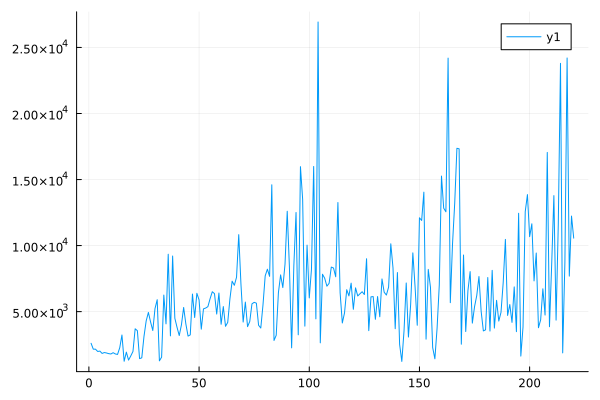

In [14]:
using Plots
ex = E`JuliaRL_BasicDQN_Vtol`
run(ex)
plot(ex.hook.rewards)